In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from datetime import datetime
from utils import BNN
import json
import openturns as ot
import seaborn as sns

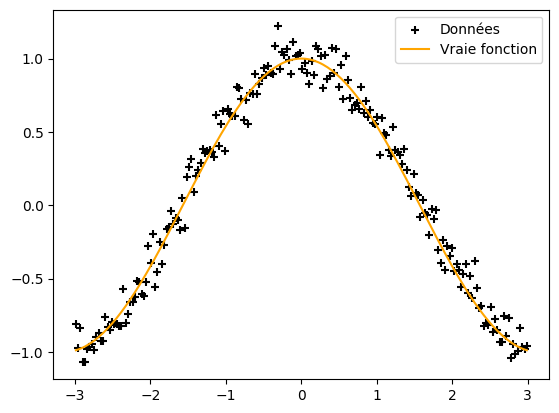

In [2]:
# Definition de la fonction de test
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return np.cos(x) + epsilon

# Paramétrage des données d'entrainements
train_size = 200
# Le bruite
noise = 0.1

# Pour cos
xmin = -3
xmax = 3

zoomfig = 2
xminBig = xmin - zoomfig * (xmax - xmin)
xmaxBig = xmax + zoomfig * (xmax - xmin)

XBig = np.linspace(xminBig, xmaxBig, train_size *
                   (2*zoomfig + 1)).reshape(-1, 1)
X = XBig[train_size * zoomfig: train_size * zoomfig + train_size]
y = f(X, sigma=noise)
y_true = f(X, sigma=0.0)


# On affiche tout ça
plt.close()
plt.scatter(X, y, marker='+', label='Données', color = 'k')
plt.plot(X, y_true, label='Vraie fonction', color = 'orange')
plt.legend()
plt.show()

In [3]:
# Convertion
XTBig = torch.Tensor(XBig).reshape(XBig.shape)
XT = torch.Tensor(X).reshape(X.shape)
y = torch.Tensor(y).reshape(y.shape)

In [4]:
# Hypperparamètres
N = 5000
lmax = 6
P0 = 0.1
epsilon = 1e-3
fact = 0.1
sigma_0 = (lmax + 1) * fact
ns = [1, 2, 1]
activation = 'tanh'

# Temperature initial
Temp = 0.5

# Distance qui va être utiliser pour évaluer
# la dissimilarité entre les prédictions y_hat et la réponse y
pdist = 2

In [5]:
# Ici on commence l'algorithm BNN-ABC-SS
# Notre modèle
myModel = BNN.FNN(ns, activation)
myModelSize = BNN.modelSize(ns)

# Distribution a priori
thetaPrior = ot.Normal(0, sigma_0)
thetas = torch.randn(myModelSize, N) * sigma_0
# Fixe la variance de la distribution de proposition
sigma_j = sigma_0

# Feedforward
y_hats = torch.concat(
    tuple([myModel.update_weights(thetas[:, i]).forward(XT) for i in range(0, N)]), 1)

# Calcul la dissimilarité
rhos = (torch.cdist(y_hats.t(), y.t(), p=pdist) ** 2)/ myModelSize

#  
rhoMin = []
rhoMax = []
epsJ = []
#
NP0 = int(N*P0)
invP0 = int(1/P0)
j = 0

# reglage de temperature
t = 0
TempCur = Temp
while (rhos[0, 0] > epsilon):

    # On trie les erreurs et on mets les poids dans
    # l'ordre croissant des érreurs qu'ils produisent
    rhos, indices = torch.sort(rhos, 0)

    rhoMin.append(str(np.float32(torch.min(rhos).detach())))
    rhoMax.append(str(np.float32(torch.max(rhos).detach())))

    thetas = thetas[:, indices.t()[0]]

    epsilon_j = rhos[NP0]
    epsJ.append(str(np.float32(epsilon_j[0].detach())))
    
    # Ici on a un échantillion de taille NP0 et on veut
    # en créer N à partir de cette échantillion en fesant
    # (invPO - 1) pas
    thetasSeeds = thetas[:, :NP0]
    rhoSeeds = rhos[:NP0]

    # Réglage de sigma_j
    sigma_j = sigma_0 - fact * lmax

    #
    thetas = thetasSeeds
    rhos = rhos[:NP0]

    for g in range(invP0 - 1):
        # thetasResamples = torch.normal(thetasSeeds, sigma_j)
        thetasResamples = thetasSeeds + \
            torch.randn(thetasSeeds.shape) * sigma_j

        # redimensionement des thetas
        tThetasSeeds = thetasSeeds.t().ravel().reshape(myModelSize * NP0, 1)
        tThetasResamples = thetasResamples.t().ravel().reshape(myModelSize * NP0, 1)

        # Calcul des probabilité p(theta^{(n-1)}) (seeds) et p(theta') (Resamples)
        ptThetasSeeds = torch.Tensor(
            thetaPrior.computePDF(tThetasSeeds.detach().numpy()))
        ptThetasResamples = torch.Tensor(
            thetaPrior.computePDF(tThetasResamples.detach().numpy()))

        rj = torch.exp(( ptThetasResamples - ptThetasSeeds )/ TempCur)
        # rj = ptThetasResamples / ptThetasSeeds

        sj = torch.minimum(torch.ones(myModelSize * NP0, 1), rj)
        
        # bj = torch.bernoulli(sj)
        bj = (torch.rand(sj.shape) <= sj).float()

        thetasNow = (bj * tThetasResamples + (1 - bj) *
                     tThetasSeeds).reshape(NP0, myModelSize).t()
        
        # On evalue les erreurs
        y_hatsNow = torch.concat(
            tuple([myModel.update_weights(thetasNow[:, i]).forward(XT) for i in range(0, NP0)]), 1)        
        rhoNow = (torch.cdist(y_hatsNow.t(), y.t(), p=pdist) ** 2) / myModelSize
        mask = torch.diag((rhoNow <= epsilon_j).ravel().float())
        
        rhoVal = mask @ rhoNow + (torch.eye(NP0) - mask) @ rhoSeeds
        thetaVal = thetasNow @ mask + thetasSeeds @ (torch.eye(NP0) - mask)

        # Mise à jour
        thetasSeeds = thetaVal
        thetas = torch.concatenate((thetas, thetasSeeds), 1)
        rhoSeeds = rhoVal
        rhos = torch.concatenate((rhos, rhoSeeds))

        # Réglage de la température
        TempCur = Temp / np.log(2 + t)
        t +=1

    j += 1
    if (j >= lmax):
        break


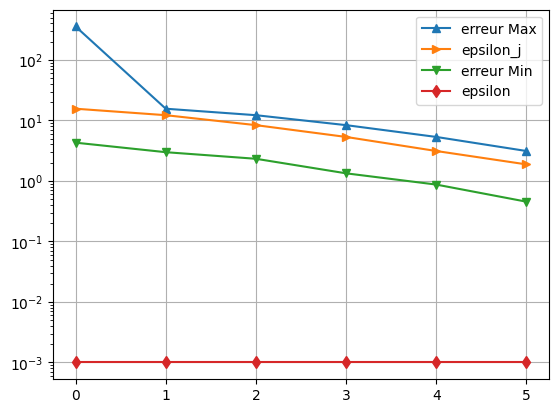

In [15]:
plt.figure()
plt.plot(np.float32(rhoMax), label = 'erreur Max', marker = '^')
plt.plot(np.float32(epsJ), label = 'epsilon_j', marker = '>')
plt.plot(np.float32(rhoMin), label = 'erreur Min', marker = 'v')
plt.plot(np.ones(len(rhoMin)) * epsilon, label = 'epsilon', marker = 'd')
plt.yscale('log')
plt.legend()
plt.grid('on')
plt.show()

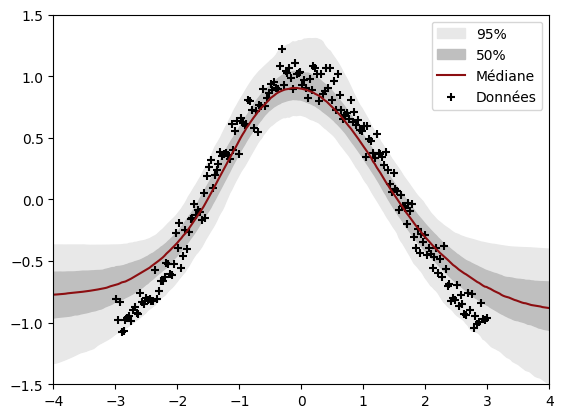

In [9]:
plt.clf()
BNN.plotTubeMedianBig(XT, XTBig, y, thetas, ns, activation, 1)
plt.xlim(-4, 4)
plt.ylim(-1.5, 1.5)
plt.show()
plt.pause(0.1)

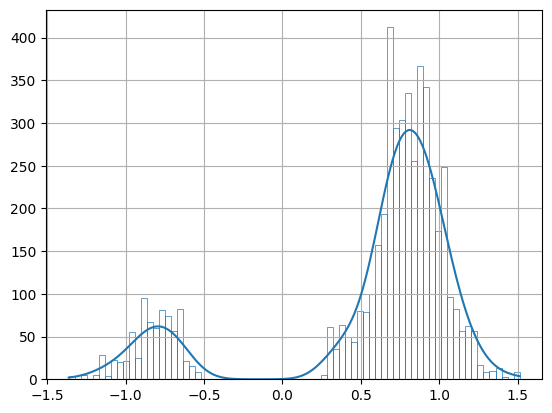

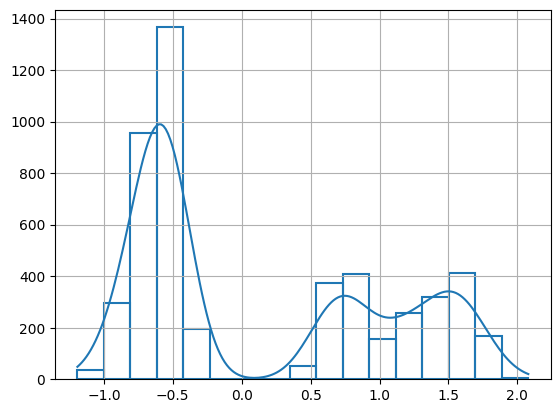

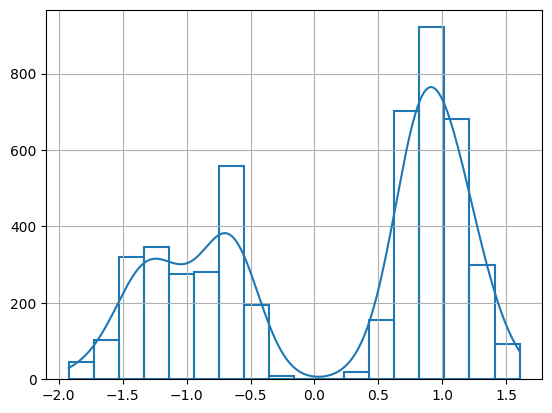

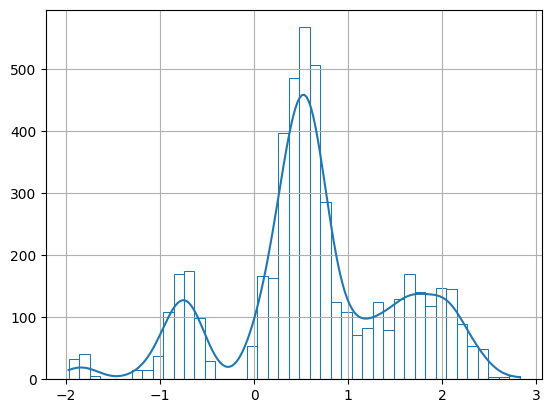

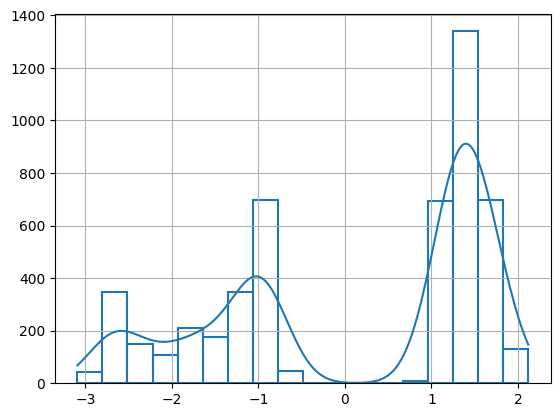

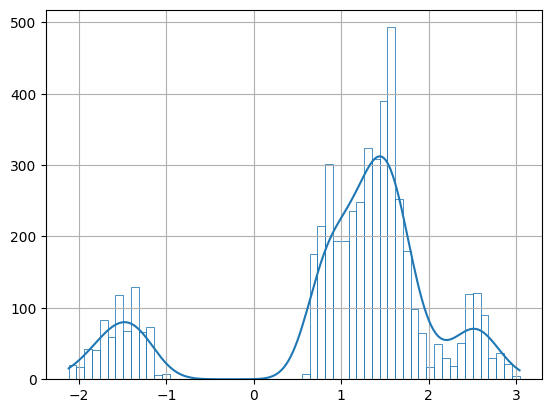

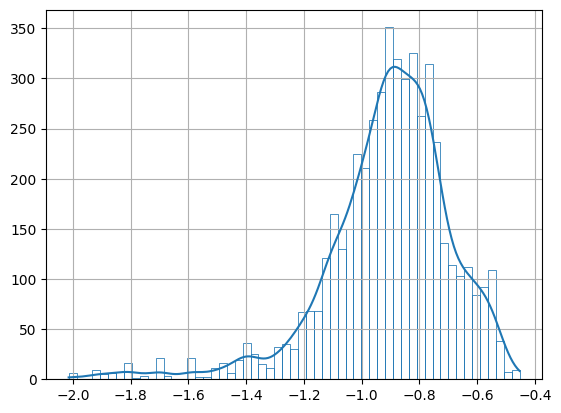

In [10]:
for k in range(thetas.shape[0]) :
    plt.figure()
    sns.histplot(thetas[k,:].detach().numpy(), kde = True, fill = False)
    plt.grid('on')
    plt.ylabel(None)

<Figure size 640x480 with 0 Axes>

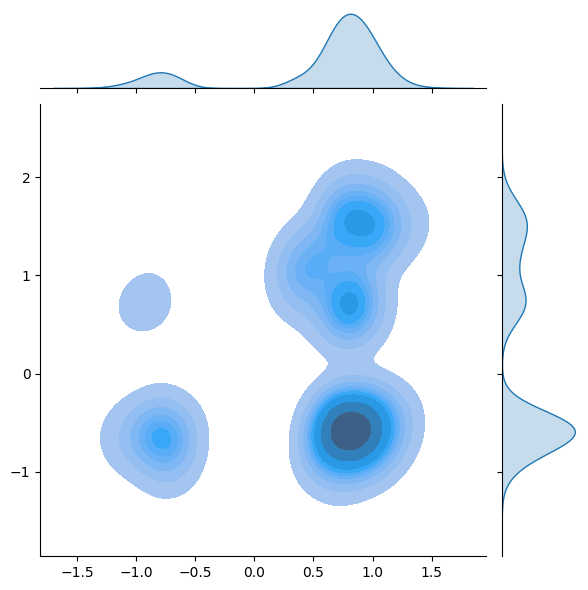

In [11]:
plt.figure()
s = 0
d = 1
sns.jointplot(x = thetas[s,:].detach().numpy(), y = thetas[d,:].detach().numpy(), kind='kde', fill=True)
plt.show()

In [12]:
y_hats = torch.concat(
        tuple([myModel.update_weights(thetas[:, i]).forward(XTBig) for i in range(0, N)]), 1)

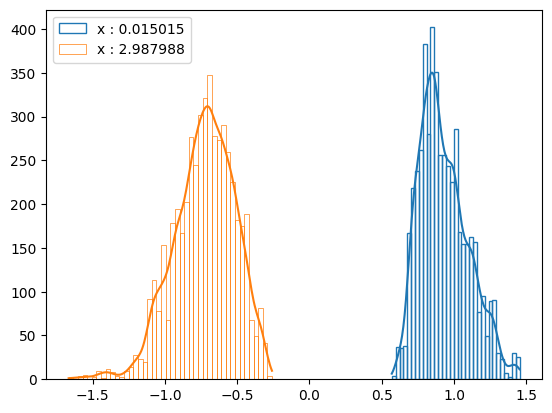

In [13]:
middle = torch.argmin(torch.abs(XTBig))
left = middle + 100
sns.histplot(y_hats[middle + 1,:].detach().numpy(), kde = True, label = 'x : {:2f}'.format(XTBig[middle+1][0]), fill = None)
sns.histplot(y_hats[left,:].detach().numpy(), kde = True, label = 'x : {:2f}'.format(XTBig[left][0]), fill = None)
plt.ylabel(None)
plt.legend()